### [Exp-15] 문자를 읽을 수 있는 딥러닝

##### 여행사에서 여행준비부터 여행하는 동안 사용할 수 있는 OCR 서비스  
- 신분증/명함을 OCR로 인식한다.   
- 필요 서류에 올바로 기입되었는지 확인한다.  
- 해당 폼 및 손글씨를 인식하여 신분증과 대조 확인하여 오기 방지.  
- 여행가서 간판에 쓰여진 글씨를 식별하여 번역할 수 있다.  
- 안내 표지판을 인식하여 올바른 길로 이동할 수 있다.  
- 쇼핑하다가 잡지를 구매함.;  

### setup

tesseract 라이브러리 설치  
tesseract-ocr-kor - 한국어용 tesseract-ocr 언어 파일  
tesseract-ocr-jpn - 일본어용 tesseract-ocr 언어 파일  
tesseract-ocr-kor-vert - tesseract-ocr language files for Korean (vertical)   
vertical 타입은 설치 안함.
 

환경변수 설정  
export TESSDATA_PREFIX=/usr/share/tesseract-ocr/4.00/tessdata  

In [25]:
import matplotlib.pyplot as plt
import keras_ocr
import numpy as np
import cv2
import glob

#! sudo apt install tesseract-ocr
#! sudo apt install libtesseract-dev
#! sudo apt install tesseract-ocr-kor
#! sudo apt install tesseract-ocr-jpn
#! export TESSDATA_PREFIX=/usr/share/tesseract-ocr/4.00/tessdata 

import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
# ~/.keras-ocr/craft_mlt_25k.h5 ~/.keras-ocr/crnn_kurapan.h5 .h5는 저장된 모델.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/evergrin/.keras-ocr/craft_mlt_25k.h5
Looking for /home/evergrin/.keras-ocr/crnn_kurapan.h5


##### Step1. 검증용 데이터셋 준비

언어를 알 수 있도록 파일명에 prefix로 "kor", "eng"등을 추가함.  
ocr인식시 파일명을 파싱하여 lang에 입력.  

In [71]:
import requests
import urllib
from io import BytesIO
from PIL import Image
import wget

image_urls = [
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/eng_ocr01.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/eng_ocr02.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/eng_ocr03.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/eng_ocr04.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/eng_ocr05.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/kor_ocr06.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/kor_ocr07.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/kor_ocr08.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/kor_ocr09.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/jpn_ocr10.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/jpn_ocr11.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/kor_ocr12.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/kor_ocr13.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/kor_ocr14.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/eng_ocr15.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/kor_ocr16.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/kor_ocr17.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/eng_ocr18.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/kor_ocr19.png',
  'https://github.com/evergrin98/aiffel/blob/main/exp_node/data/ocr/kor_ocr20.png',
]

imgs_dir = os.getenv('HOME') + '/ocr_imgs/'
images_paths = []

if not os.path.exists(imgs_dir):
      os.mkdir(imgs_dir)

for img_url in image_urls:
      file_path = os.path.join(imgs_dir, os.path.basename(img_url))
      urllib.request.urlretrieve(img_url+'?raw=true', file_path)
      images_paths.append(file_path)

print(len(images_paths), "images")

20 images


In [72]:
# imgs_dir = '/home/evergrin/python/notebook/data/ocr/imgs'
images_paths = glob.glob(os.path.join(imgs_dir, "*.png"))

images_paths = sorted(images_paths, key=lambda x: os.path.basename(x)[4:], reverse=False)
print(len(images_paths), "images")

20 images


##### Step2. keras-ocr, Tesseract로 테스트 진행

tesseract는 언어별 지원이 가능하므로, 영어와, 한국어를 테스트한다.  
한국어와 영어는 혼용된 곳이 많으므로, lang옵션으로 "eng+kor" 형태로 입력 가능함.  

In [74]:
def get_lang(img_path):
    file, ext = os.path.splitext(os.path.basename(img_path))
    lang = file[0:3]
    if 'kor' == lang:
        lang = "kor+eng"
    elif 'jpn' == lang:
        lang = "jpn+eng"

    return lang

이미지중 일부는 alpha채널로 4채널이 있거나, 1채널인 경우도 있어서 동작시 에러가 발생함.  
이에 shape을 3dim, 3채널로 변경해줌.  

In [75]:
def ocr_check(img_path, custom_oem_psm_config=None):
    '''
    img_path를 입력받아 keras-ocr, tesseract-ocr 테스트를 수행함.
    '''
    img = Image.open(img_path)
    img_ary = np.asarray(img)
    
    # 채널이 하나인 경우, 3개로 만들어줌.
    if img_ary.ndim == 2:
        img_ary = np.expand_dims(img_ary, axis=2)
        img_ary = np.concatenate([img_ary, img_ary, img_ary], axis=2)
    
    # 채널이 4개인경우, 3개로 만들어줌.  
    if img_ary.shape[2] == 4:
        img_ary = img_ary[:, :, :3]

    # keras-ocr
    predictions = pipeline.recognize([img_ary])[0]

    # tesseract-ocr
    # OCR Engine modes(–oem):
    # 0 - Legacy engine only.
    # 1 - Neural nets LSTM engine only.
    # 2 - Legacy + LSTM engines.
    # 3 - Default, based on what is available.

    # Page segmentation modes(–psm):
    # 0 - Orientation and script detection (OSD) only.
    # 1 - Automatic page segmentation with OSD.
    # 2 - Automatic page segmentation, but no OSD, or OCR.
    # 3 - Fully automatic page segmentation, but no OSD. (Default)
    # 4 - Assume a single column of text of variable sizes.
    # 5 - Assume a single uniform block of vertically aligned text.
    # 6 - Assume a single uniform block of text.
    # 7 - Treat the image as a single text line.
    # 8 - Treat the image as a single word.
    # 9 - Treat the image as a single word in a circle.
    # 10 - Treat the image as a single character.
    # 11 - Sparse text. Find as much text as possible in no particular order.
    # 12 - Sparse text with OSD.
    # 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.    
    
    if None == custom_oem_psm_config:
        custom_oem_psm_config = r'--oem 3 --psm 3'
    
    datas = pytesseract.image_to_data(img, 
                                      config=custom_oem_psm_config,
                                      output_type=Output.DICT, 
                                      lang=get_lang(img_path))
    
    return predictions, datas


keras와 tesseract가 글자를 어떻게 인식하는지 확인하기 위해 text box를 비교함.  

In [76]:
def draw_text_boxes(img_path, predictions, datas):
    
    img = Image.open(img_path)
    img_keras = img.copy()
    img_cv = cv2.imread(img_path)
    
    fig, axes = plt.subplots(1, 3, figsize=(15,5))

    # show original img
    axes[0].imshow(img)
    axes[0].set_title(os.path.basename(img_path))

    # show keras-ocr result
    img_ary2 = keras_ocr.tools.drawBoxes(image=np.asarray(img), 
                                         boxes=predictions, 
                                         boxes_format='predictions', 
                                         thickness=1)
    axes[1].imshow(img_ary2)
    axes[1].set_title('keras')
    # keras_ocr.tools.drawAnnotations(image=img_ary, 
                                    # predictions=predictions, 
                                    # ax=axes[1])

    # show tesseract-ocr boxes
    n_boxes = 0
    try:
        n_boxes = len(datas['level'])
    except:
        n_boxes = 0

    for i in range(n_boxes):
        (x, y, w, h) = (datas['left'][i], datas['top'][i], datas['width'][i], datas['height'][i])
        cv2.rectangle(img=img_cv, pt1=(x, y), pt2=(x + w, y + h), 
                      color=(0, 255, 0), thickness=1)

    axes[2].imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    axes[2].set_title('tesseract')
    plt.show()

keras와 tesseract가 인식된 글자를 비교함.  
keras는 영어만 지원하여 한글은 오인식됨.  

In [77]:
def show_texts(img_path, predictions, datas):

    keras_texts = [text for text, box in predictions]
    keras_texts = [ s for s in keras_texts if len(s) > 0 ]

    img = Image.open(img_path)
    tessracts_strings = pytesseract.image_to_string(img, lang=get_lang(img_path))
    tessracts_strings = tessracts_strings.split('\n')
    tessracts_strings2 = []
    tessracts_strings3 = []
    for s in tessracts_strings:
        tessracts_strings2.extend(s.split(','))
    for s in tessracts_strings2:
        tessracts_strings3.extend(s.split(' '))
    tessracts_strings3 = [ s for s in tessracts_strings3 if len(s) > 0 ]

    maxline = max(len(keras_texts), len(tessracts_strings3))
    maxlen = max([len(keras_texts[i]) for i in range(len(keras_texts))]) + 2
    keras_prompt = '== keras-ocr =='
    tessract_prompt = '== tesseract-ocr =='
    maxlen = max(maxlen, len(keras_prompt))
    
    format_str = "%%%ds : %%s"%(maxlen)
    print(format_str%(keras_prompt, tessract_prompt))
    for i in range(maxline):
        keras_text = ""
        if i < len(keras_texts):
            keras_text = keras_texts[i]

        tesse_text = ""
        if i < len(tessracts_strings3):
            tesse_text = tessracts_strings3[i]
        
        print(format_str%(keras_text, tesse_text))    


In [78]:
def compare_ocr(img_path, custom_oem_psm_config=None):
    predictions, datas = ocr_check(img_path, custom_oem_psm_config)
    draw_text_boxes(img_path, predictions, datas)
    show_texts(img_path, predictions, datas) 

##### Step3. 테스트 결과 정리

1/1 [==============================] - 4s 4s/step


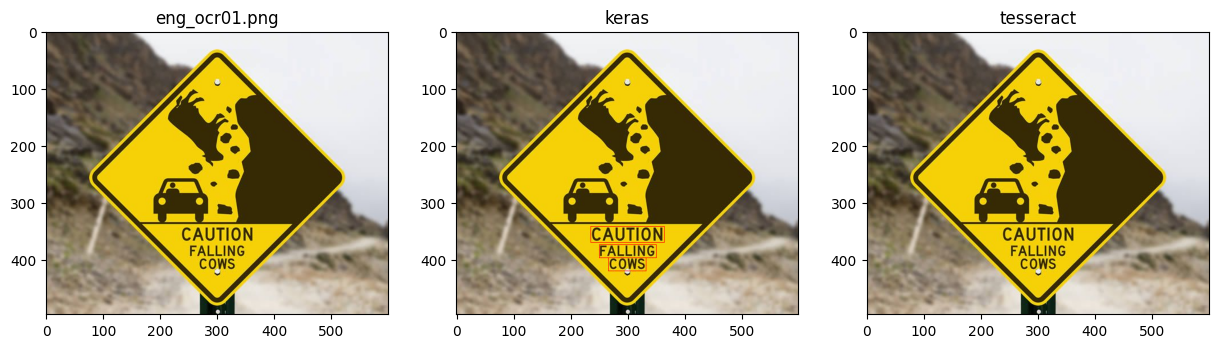

== keras-ocr == : == tesseract-ocr ==
        caution : 
        falling : 
           cows : 


2022-11-10 18:07:44.433281: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 410480640 exceeds 10% of free system memory.
2022-11-10 18:07:44.860333: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 410480640 exceeds 10% of free system memory.
2022-11-10 18:07:45.314585: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 410480640 exceeds 10% of free system memory.
2022-11-10 18:07:47.157222: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 410480640 exceeds 10% of free system memory.


3/3 [==============================] - 16s 4s/step


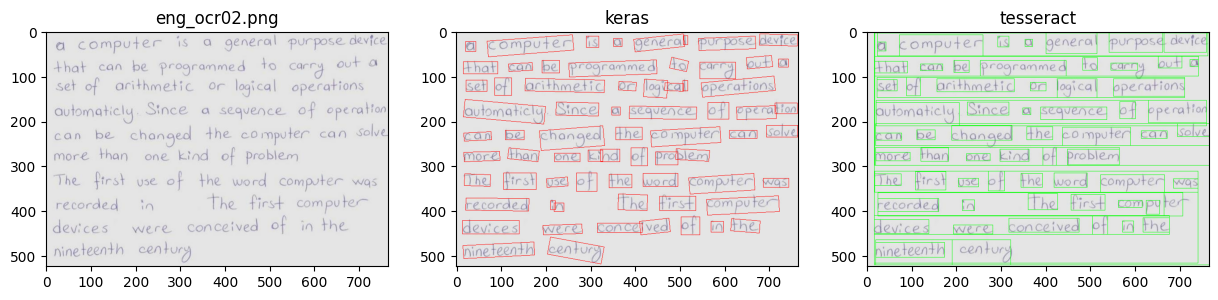

== keras-ocr == : == tesseract-ocr ==
        clevice : a
              i : computer
             is : is
       computer : a
        purpose : general
              a : purpose
         genero : device
              a : +hat
            out : can
             to : be
              a : programmed
             pe : to
     programmed : carry
           that : out
          carry : a
            can : set
             of : of
     arithmetic : arithmetic
     operations : or
           logi : logical
            set : operations
              i : automaticly.
             or : Since
             ca : a
          since : sequence
             of : of
           tion : operation
    automaticly : can
       seevence : be
          opera : chanoed
              a : the
          solve : computer
        changed : can
            the : solve
       computer : more
             be : than
            caa : one
            can : kind
           than : of
             of : problem
             n

2022-11-10 18:08:55.623462: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 645324800 exceeds 10% of free system memory.


3/3 [==============================] - 18s 5s/step


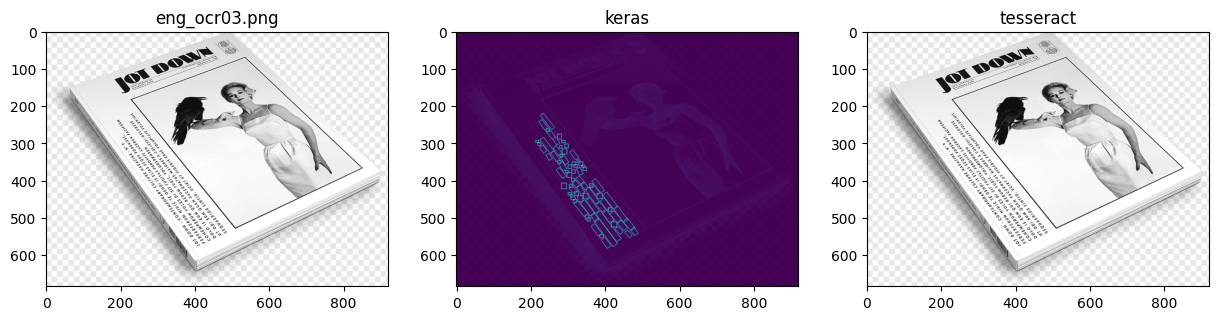

== keras-ocr == : == tesseract-ocr ==
        inineio : 
           ssyo : 
              d : 
            sog : 
              s : 
             es : 
         nuetke : 
             ee : 
             de : 
              c : 
              e : 
             bo : 
            nss : 
              d : 
            vue : 
           flla : 
              e : 
             ya : 
             bo : 
              s : 
             te : 
              e : 
              s : 
            ses : 
              c : 
              s : 
             te : 
              s : 
              e : 
           vite : 
              e : 
             le : 
              e : 
            tid : 
              s : 
          efioa : 
             ad : 
              d : 
            ded : 
              s : 
              c : 
             ne : 
            ves : 
            jis : 
          wnesy : 
              s : 
              s : 
              c : 
              s : 
         oilnis : 
           

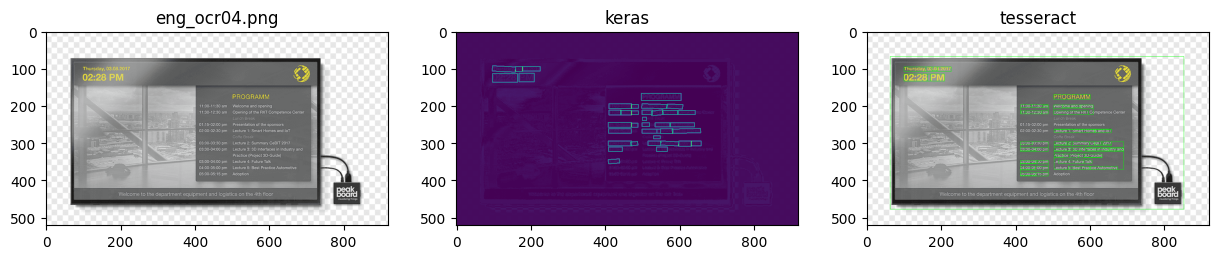

== keras-ocr == : == tesseract-ocr ==
       thgsoays : Re
             db : Ku
         dezott : 02:28
             pm : PM
          02128 : roe
       programm : it
        tornies : eeepc
           rtns : (acne
             ar : Career
              t : Cocecr
            tis : ios
             gu : Peete
            aon : Cece
           nxes : PROGRAMM
          coles : eee
           deas : Cronin
             sa : Renesas
              l : elm
          cuuns : Lecture
             ss : 2:
            ata : Summary
        reatons : CeBIT
             pe : 2017
         cltean : ete
           sren : ner
        ronstnn : cae
           scns : ae
              r : Ere
           coae : eoe
         ratcrn : ecco)
             td : Steen
           catn : Cee
           nsun : eto
           sran : 
             de : 
             te : 
            see : 
             di : 
4/4 [==============================] - 25s 6s/step


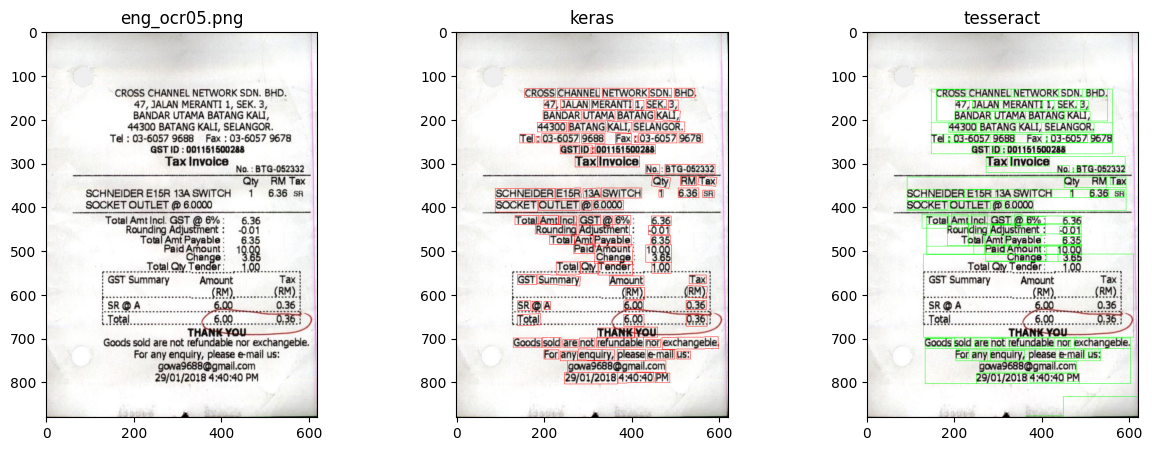

   == keras-ocr == : == tesseract-ocr ==
           channel : CROSS
           network : CHANNEL
               sdn : NETWORK
               bhd : SDN.
             cross : BHD.
             jalan : 47
           meranti : JALAN
               sek : MERANTI
                47 : 1
                 1 : SEK.
                 3 : 3
            bandar : BANDAR
             utama : UTAMA
            batang : BATANG
              kali : KALI
            batang : 44300
              kali : BATANG
         selangors : KALI
             44300 : SELANGOR.
            036057 : Tel
           0316057 : :
              9888 : 03-6057
               fax : 9688
              9678 : Fax
               tel : :
                 d : 03-6057
                 s : 9678
      00115150028s : GST
               gst : ID
                id : :
                 s : 001151500288
               tax : Tax
           invoice : Invoice
         btg052332 : No.
                no : :
               qty : BTG-052332
   

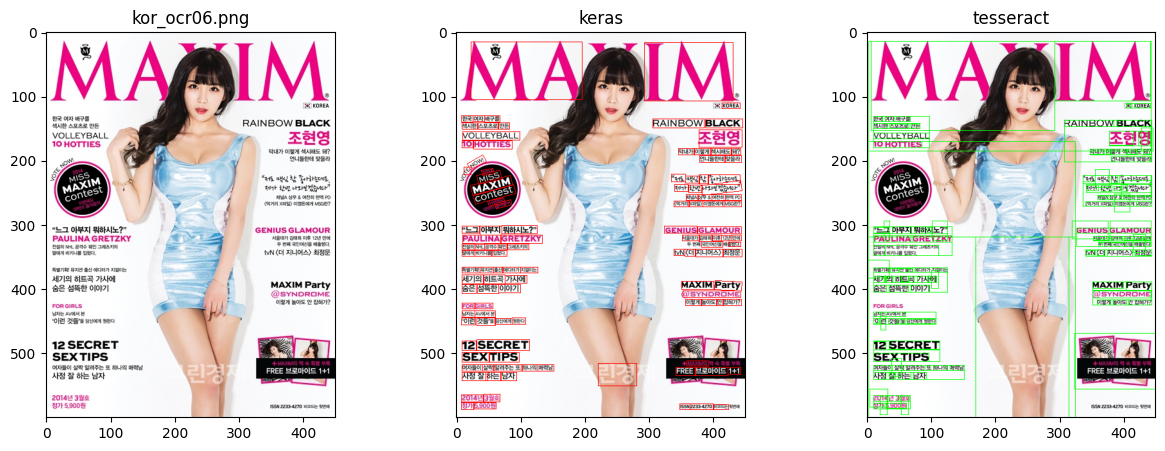

== keras-ocr == : == tesseract-ocr ==
             ma : 3
             im : of
          korea : Sle
             ls : azae
            oly : ge
            upe : VOLLEYBALL
        rainbow : 1OHOTTIES
          black : 느그
           mast : 아부지
           auae : 뭐하시노?"
            die : PAULINA
           tolo : GRETZKY
     volleyball : foun
             10 : seri
        hotties : pn
           oupt : ae
            oln : EPRI
            ass : 세기의
             tx : 히트곡
          olsse : 가사에
            oet : SS
            now : A881
              s : 010171
           zova : 0000
           miss : '이건
             us : 것들찌아
              k : 12
      tohrecilz : SECRET
            iua : SEXTIPS
          maxim : imo
          ciiec : arm
            1ht : were
             tr : ai}
        contest : ote
            tea : 사정
            apa : 잘
            ote : 하는
          tripd : 남자
           ooes : 2014년월트
           soto : 절가5900원
            sae : IM.
            chd : ‘=
   

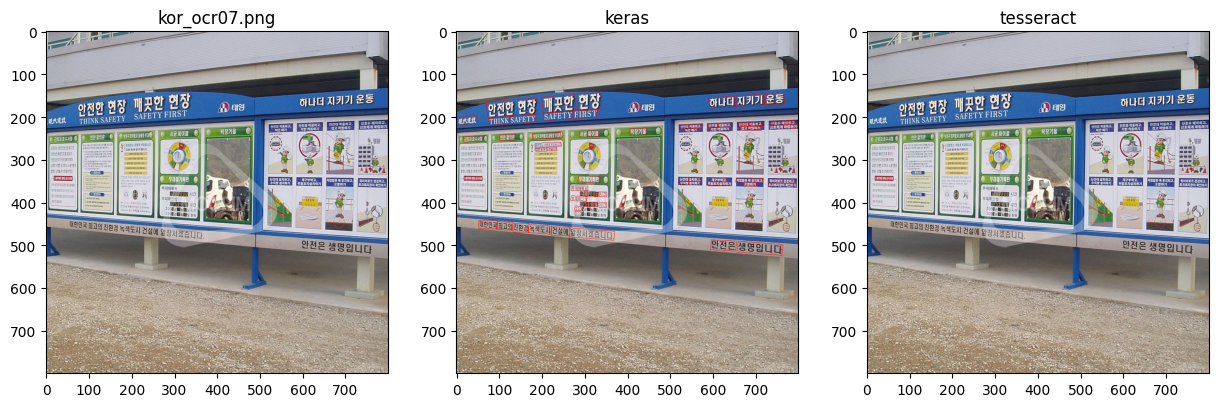

== keras-ocr == : == tesseract-ocr ==
             00 : 
              g : 
          tfiji : 
           thot : 
          oflye : 
          otoot : 
            eho : 
          first : 
         safety : 
         safety : 
           lrsi : 
          think : 
         noeune : 
           sgee : 
            sua : 
           caee : 
            gun : 
        sugezer : 
         nacuee : 
          saeae : 
           saeg : 
            she : 
           sepi : 
            ios : 
             na : 
          setng : 
          alage : 
         saeans : 
      mblemniue : 
      ouldaelle : 
         aivies : 
            hoe : 
           anen : 
           faea : 
      ntealanez : 
         soeaus : 
            pes : 
           caon : 
        mmhnezi : 
            aae : 
        suenses : 
          eutee : 
         oooooo : 
             ae : 
          gneey : 
           seed : 
             aa : 
           20os : 
            200 : 
            hle : 
           

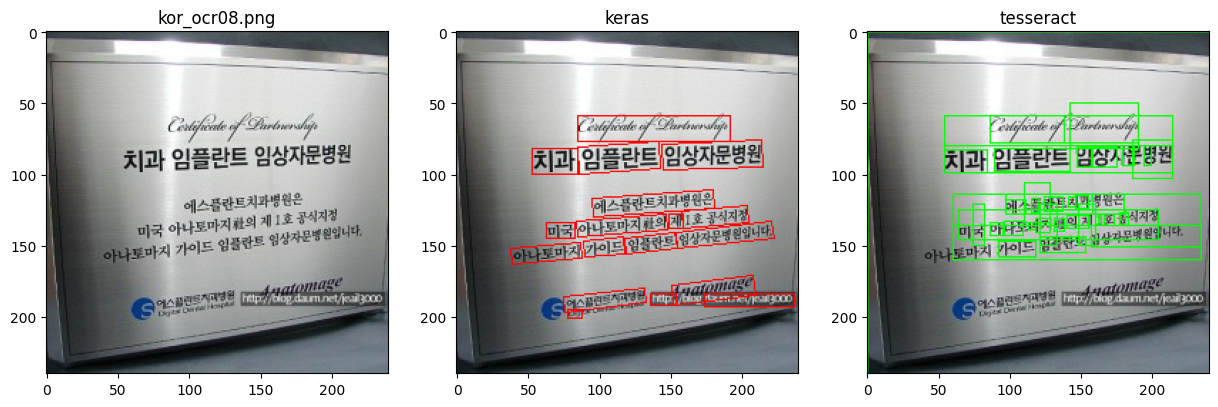

== keras-ocr == : == tesseract-ocr ==
     crigoarbos : Cher
            ote : Darth
         oleete : 치과
            ant : 임플란트
    olsoteahses : 임상자문병원
         itsaly : 에스플란드치경은
             2l : 나국
     offentlits : 아나도마지#의제
            vle : 1호구43
      olahesclt : 이드
          sluts : Ga
           fole : ENE
        ofliufy : 
      tuatonage : 
         uusats : 
          haips : 
      dmncteoos : 
             da : 
3/3 [==============================] - 22s 7s/step


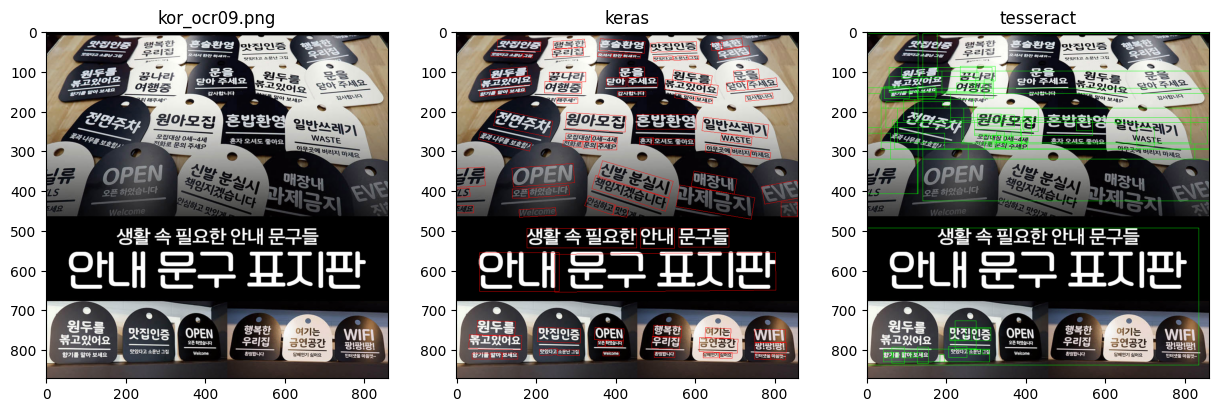

== keras-ocr == : == tesseract-ocr ==
            ses : 공아라
           ghse : Pr
           eteg : BE
           axes : oss
            ces : 여랭중
             sn : rot
            set : nea
           pels : ~
          resae : re
             as : -
            cis : Lee?
         stanse : 원아모집
            sel : 2
             ee : =
          oacia : &
             ss : pat
             ts : 2
             rs : 오점대상0세~4세
             ss : IAS)
          zlfet : "
         snaois : 로
            ais : 문의
           crot : 주세요
              a : 맛집인증
           rios : 향기를말아보시요
           etoe : 을
          oigha : 맛있다고
            ais : 소문난
            sot : 그집
            gle : 
       zatelict : 
           laoh : 
           gaee : 
          sails : 
         shaals : 
           tost : 
         sjofot : 
            sus : 
        etaatpn : 
       nlfalsst : 
          gacha : 
          waste : 
          oalai : 
            exh : 
         saseos : 
            tit : 
       

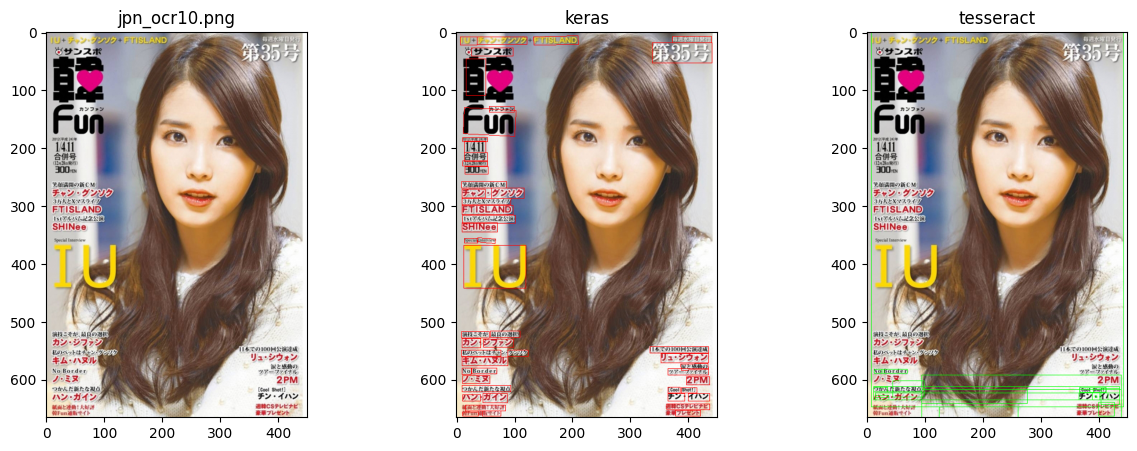

== keras-ocr == : == tesseract-ocr ==
       ftisland : No
           anee : Border
            jut : {coat
           frze : shot}
            136 : Dink
           sozt : RMA)
              f : ハン
          npzay : チン・イハン
            fun : 
          otiae : 
           141l : 
           aufs : 
            aon : 
           jooe : 
         roticm : 
            srs : 
            fre : 
      bilexzzed : 
       ftisland : 
      isonatzan : 
         shinee : 
           tead : 
       intermes : 
             tl : 
         filein : 
           hros : 
             je : 
          sated : 
    hscotooleid : 
         eoseet : 
           dear : 
        ujeoszr : 
          floxw : 
         weathe : 
             no : 
         boudeu : 
          ezied : 
          joebs : 
            2pm : 
        thetrta : 
           cool : 
          shord : 
            jee : 
              f : 
             di : 
             se : 
       acstlete : 
      cetaizaln : 
            lel

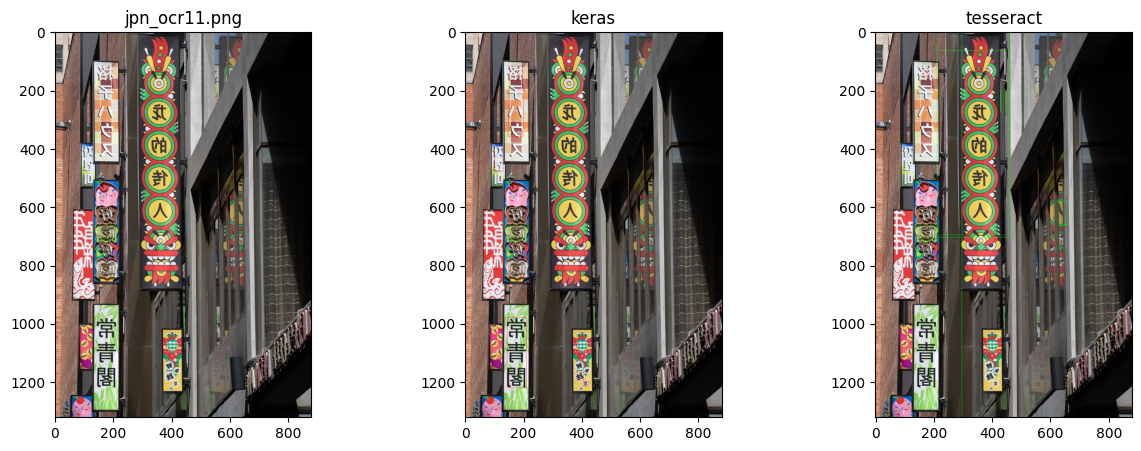

== keras-ocr == : == tesseract-ocr ==
             ss : ディポ
              a : mpgGe:
              e : 
              e : 
              e : 
              e : 
              k : 
             st : 
1/1 [==============================] - 1s 1s/step


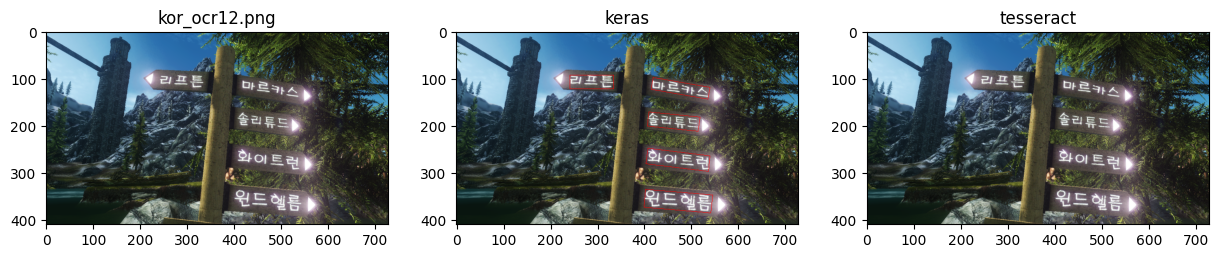

== keras-ocr == : == tesseract-ocr ==
             ee : 
         dpeahe : 
           eaee : 
          choer : 
           heds : 
1/1 [==============================] - 5s 5s/step


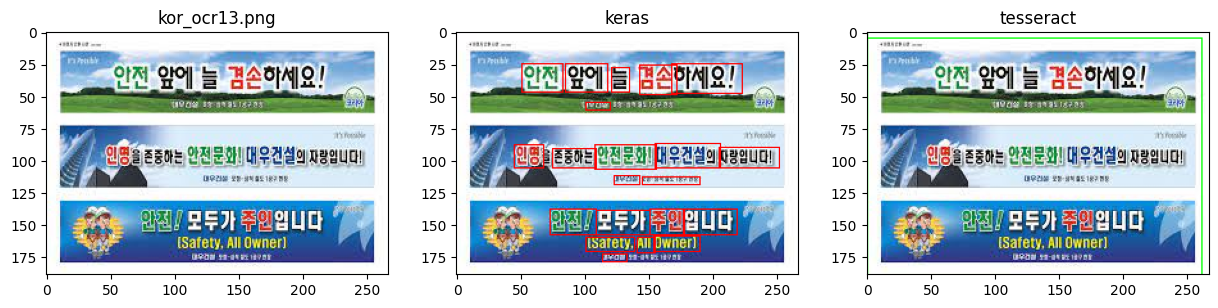

== keras-ocr == : == tesseract-ocr ==
              o : 
            h0l : 
           tiol : 
             he : 
              e : 
            loe : 
          hozyo : 
             90 : 
            oes : 
          nggug : 
           esoa : 
           dees : 
        ranliee : 
             oi : 
             t0 : 
            alg : 
              9 : 
         ownerd : 
        isatery : 
            all : 
           dean : 
1/1 [==============================] - 4s 4s/step


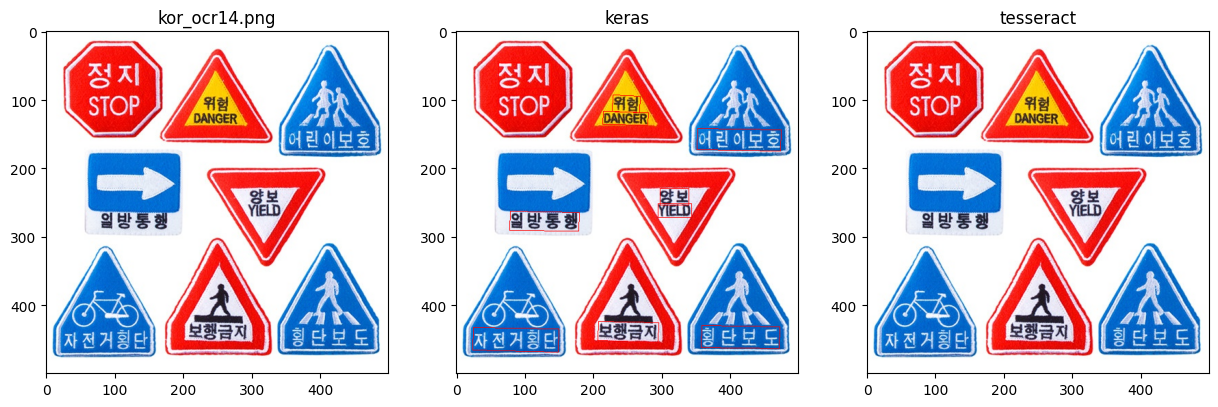

== keras-ocr == : == tesseract-ocr ==
             tt : 
           stop : 
             ag : 
         danger : 
          olots : 
             cy : 
          yield : 
            aag : 
           eoet : 
          geits : 
            ahg : 
1/1 [==============================] - 3s 3s/step


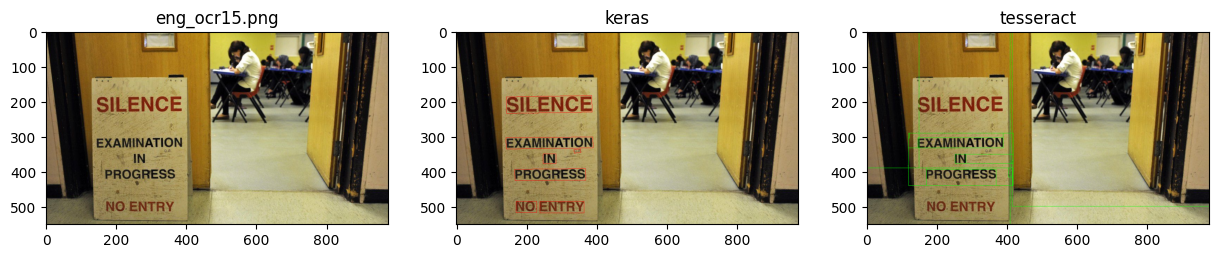

== keras-ocr == : == tesseract-ocr ==
        silence : )
    examination : EXAMINATION
            des : IN
             in : -§
       progress : PROGRESS
             no : |
          entry : 
5/5 [==============================] - 34s 6s/step


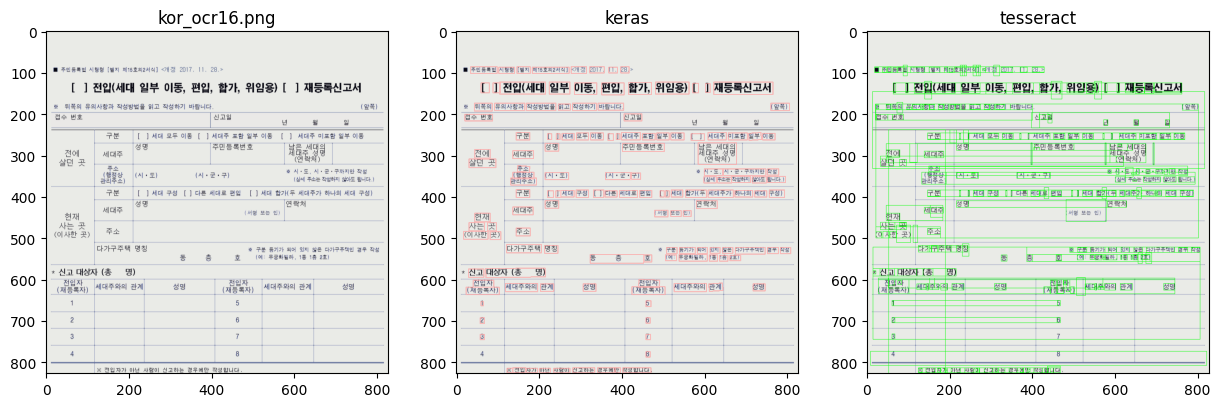

== keras-ocr == : == tesseract-ocr ==
         felsee : @
          isezl : 주민등록범
           szhg : 시행령
           2017 : [벌지
             2e : 제15호의2서식]
            agg : <개정
      1115724ai : 2017
             ll : 11
        tioaich : 28.>
             1t : [
             os : ]
        ahassin : 전입(세대
              l : 일부
              1 : 이동
            ola : 편입
            ull : 합가
           stzl : 위임용)
              l : [
              j : ]
             ze : 재등록신고서
        raargiy : ※
           hggi : 뒤쪽의
          hgszi : 유의사항과
            cyd : 작성방법을
             hn : 읽고
         uthhch : 작성하기
            tns : 바랍니다.
           aine : 접수
             te : 번호
          michz : (23)
          miciz : !고일
           olet : lhe
           ajch : 년
             fe : a
            ols : 일
             ye : 구분
             04 : |
            ols : [
             84 : ]
            ols : 세대
              l : 모두
              t : 이동
              l : ]
              t : 세대주
        

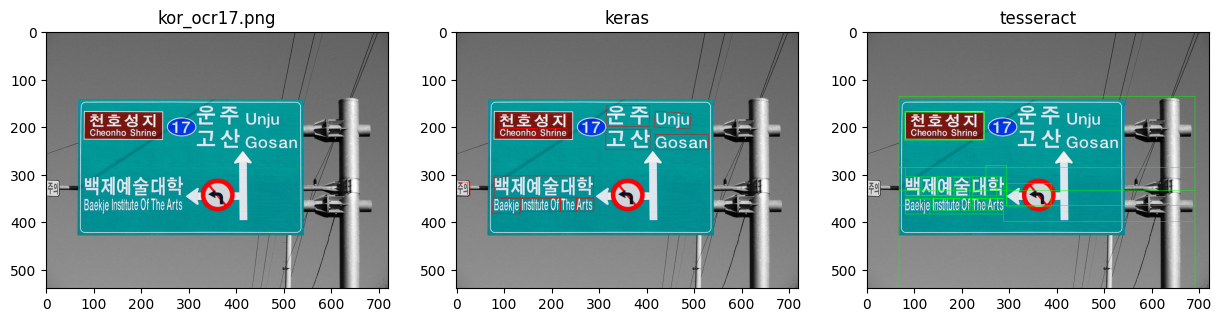

== keras-ocr == : == tesseract-ocr ==
             st : 백제예술대학
           unju : Baekje
           taat : Institute
        cheonho : Of
         shrine : The
           tzas : Arts
          gosan : <0
          tloea : 
             to : 
             of : 
            the : 
           arts : 
         backie : 
        instute : 
2/2 [==============================] - 10s 2s/step


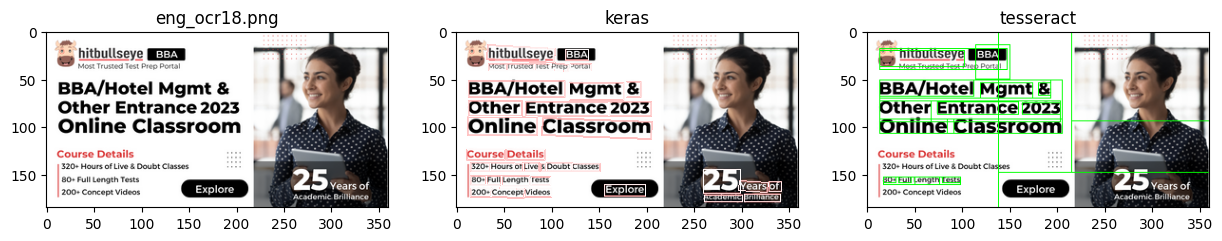

== keras-ocr == : == tesseract-ocr ==
    hitbullseye : ons:
            bba : am
           moss : BBA/Hotel
        trusiss : Mgmt
           test : &
           prep : Other
         poriol : Entrance
      bbayhotel : 2023
              8 : Online
           mgmt : Classroom
          other : 80+
       entrance : Ful
           2023 : Length
         online : Fests
      classroom : 
         course : 
        details : 
           szot : 
          hours : 
             of : 
           lire : 
              g : 
          doubt : 
         clases : 
             25 : 
             bo : 
           full : 
         length : 
            est : 
          years : 
             of : 
        explore : 
           2001 : 
        concept : 
         videos : 
     brilliance : 
       academic : 
1/1 [==============================] - 5s 5s/step


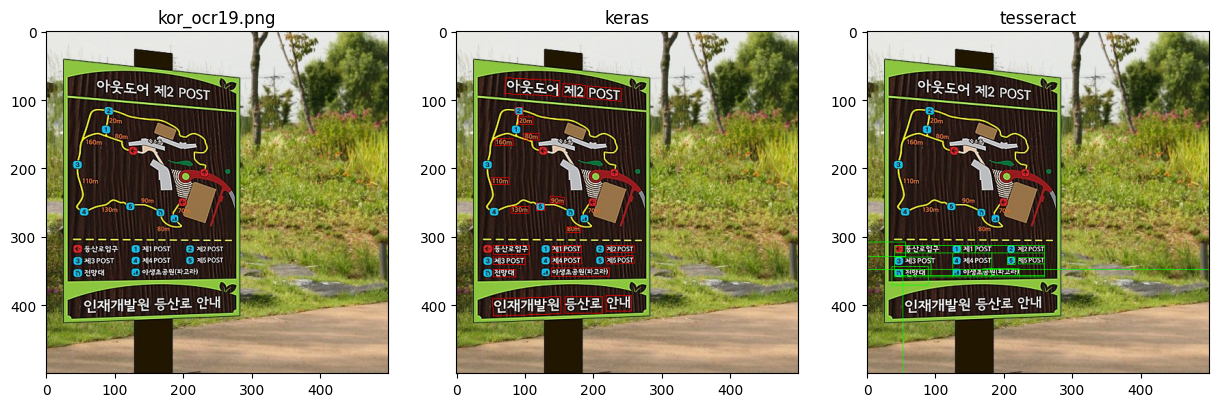

== keras-ocr == : == tesseract-ocr ==
          otiro : pon
             z2 : omnes
           post : baie
              2 : Caslpeal
            2om : PoE
            bon : ae
           icom : Srey)
           liom : 
            son : 
              6 : 
           dbom : 
            com : 
          scaet : 
           post : 
         a2post : 
             al : 
         aspost : 
        ailpost : 
         tapost : 
       onsaslne : 
           zoch : 
           otlh : 
            sse : 
       olfphete : 
3/3 [==============================] - 19s 6s/step


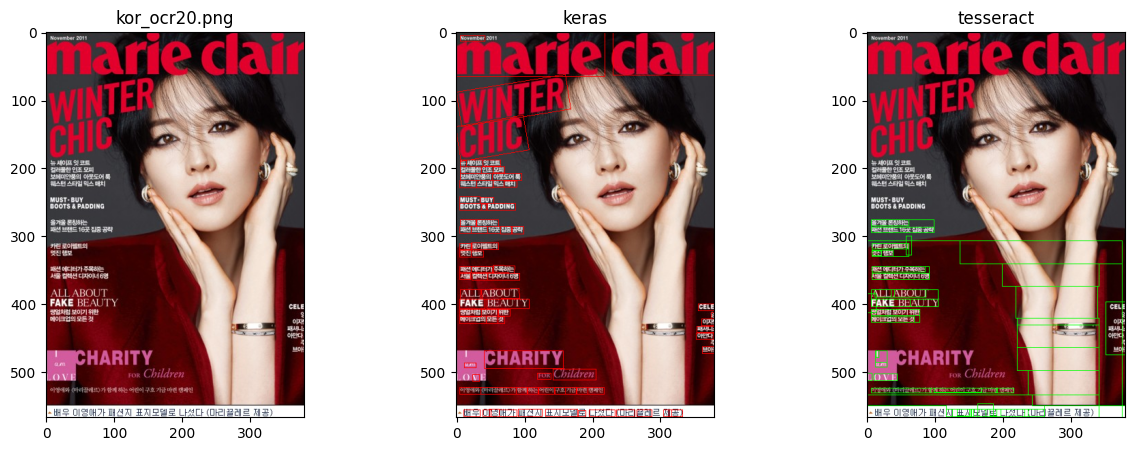

== keras-ocr == : == tesseract-ocr ==
        novmben : as
          marie : pte
          clair : 가이
         winter : 개
           chic : pat
              i : Deen
            mop : pert
             ee : ALL
          saies : ABOUT
            les : [7
             po : (고
        paopeel : ray
         olceos : Poetry
            upe : 1)
           aelo : oa
            ols : Chad
           chul : ee
           must : eee
            buy : 가
          boots : 지
        padding : 표지모델로
              a : 나섰다
            sps : (마리
          cgole : 
            dia : 
            uue : 
            16x : 
             fs : 
              s : 
            one : 
             le : 
             se : 
             ae : 
           asol : 
            ole : 
        olciepi : 
             an : 
            eie : 
        cpoliog : 
          about : 
            all : 
           fake : 
         beauty : 
           cele : 
          seute : 
           fopi : 
            hle : 
  

In [79]:
for img_path in images_paths[:]:
    compare_ocr(img_path)

1/1 [==============================] - 1s 1s/step


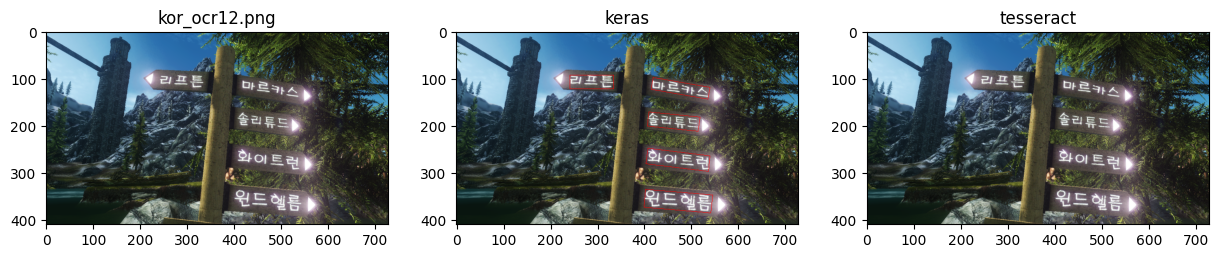

== keras-ocr == : == tessract-ocr ==
             ee : 
         dpeahe : 
           eaee : 
          choer : 
           heds : 


In [12]:
# oem: 0-3, psm: 0-13
custom_oem_psm_config = r'--oem 3 --psm 3'

compare_ocr(images_paths[11])

tesseract의 경우 아래와 같이 config옵션을 바꿔보면 box가 바뀌는 모습을 볼 수 있다.  
하지만 문자 디텍팅은 실패하고 있다.  

1/1 [==============================] - 2s 2s/step


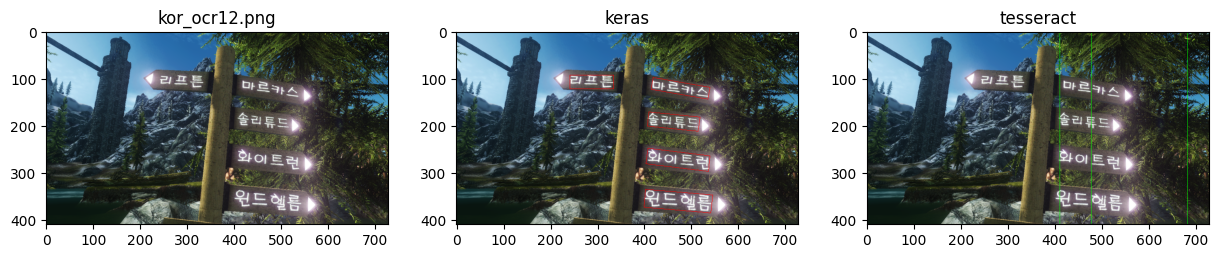

== keras-ocr == : == tesseract-ocr ==
             ee : 
         dpeahe : 
           eaee : 
          choer : 
           heds : 


In [12]:
# oem: 0-3, psm: 0-13
custom_oem_psm_config = r'--oem 1 --psm 10'

compare_ocr(images_paths[11], custom_oem_psm_config)

##### Step4. 결과 분석과 결론 제시

- keras ocr과, tesseract ocr 라이브러리를 비교해보면, 글자 위치 인식(detect)은 압도적으로 keras가 우수하다.  
- 텍스트를 찾는 box가 글자 위치 및 크기에 따라 다각형을 이루는 반면, tesseract는 직사각형 형태이고 대체로 정확한 글자위치는 찾지 못했다.    
- keras는 다국어를 지원하지 않는 반면, tesseract는 여러나라 언어를 지원하고, 한국어와 일본어도 지원되고 있다.  
- keras ocr이 detect와 recognige 모듈이 있고, 각각을 선택하여 옵션을 변경하여 동작시킬 수 도 있다.  
- tesseract는 config를 바꿔보다보면 죽는 경우가 많고, 인식안된 항목이 인식되진 않았다.    

##### Step5. 회고

여행사에서 여행서류 준비 및 여행하는 동안 사용할 수 있는 OCR서비스를 아래와같은 이미지로 테스트해보았다.  

- 신분증/명함을 OCR로 인식한다. - eng_ocr18 이미지
- 필요 서류에 올바로 기입되었는지 확인한다. - kor_ocr16 이미지
- 해당 폼 및 손글씨를 인식하여 신분증과 대조 확인하여 오기 방지. -  eng_ocr02이미지  
- 여행가서 간판에 쓰여진 글씨를 식별하여 번역할 수 있다.- eng_ocr02 이미지  
- 안내 표지판을 인식하여 올바른 길로 이동할 수 있다.- eng_ocr02 이미지  
- 쇼핑하다가 잡지를 구매함.;- eng_ocr02 이미지, eng_ocr05 이미지   

인식율이 높아야 된다는 점에서는(옵션을 많이 바꿔 보지는 않았지만..) keras가 월등했다.

먼저 서류는 폼이 일정하고, 반듯하기 때문에 두라이브러리 모두 인식율이 좋았다.   
손글씨도 이미지가 충분히 큰경우 인식이 잘되었다.  
조금만 개선하면 신분증과 서류의 데이터가 잘못들어갔는지에 대한 체크는 가능할 듯 하다.  
영수증도 올바로 detecting되었으므로 정산시 도움이 될 수 있을 것 같다.  

detecting은 사진의 각도, 글씨 크기나, 뒤틀림, 회전, 햇빛등의 영향으로 많은 부분에서 tesseract는 인식되지 않았다.   
다만 여행임을 감안해 다른 나라 언어를 인식해야하고, 일본어처럼 수직으로 쓰여진 언어도 있기 때문에 tesseract가 필요하다.  
따라서 두가지 라이브러리만 사용한다면 detect가 부족한 부분은 keras ocr에서 detect한 부분을 직사각형으로 변환하여 tesseract로 전달한다면 인식율이 올라갈것 같다.  